# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from ddpg_agent import Agent
from collections import deque
import torch
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

### 2 Load the environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='./Tennis_Windows_x86_64/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

### 5. Train the Agent with the DDPG algorithm!

Firts we will define the training function. This function recieves as input parameters:

    - `agent`: The agent to be trained.
    - `early_episode_stop`: Episode to stop the training if the agent performs well.
    - `n_max_episodes`: Maximun number of training episodes.
    - `summary_freq`: Frequency to print the average of the training process.

This function saves a the agent's critic and actor neuronal network weights in a file called `critic_best.pth` and `actor_best.pth` respectively. As the training process takes a long time, this function also save checkpoints of the weights of the neuronal networks in files called `checkpoint_critic.pth` and `checkpoint_actor.pth`. Finally, the function returns a log of the scores and the 100th moving average scores obtained along the training process.

In [8]:
def maddpg(agent, early_episode_stop=1500, n_max_episodes=2000, summary_freq=100):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    episode_scores = []                 # list containing scores from each episode
    average_scores = []                 # list containing the 100th average window scores
    scores_window = deque(maxlen=100)   # last 100 scores
    start_time = time.time()            # init time
    solved = False
    # -------------------------- Training ------------------------------------#
    for i_episode in range(1, n_max_episodes+1):
        timer = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        
        player1_state = env_info.vector_observations[0]
        player2_state = env_info.vector_observations[1]
        
        agent.reset()
        scores = np.zeros(num_agents)
        while True:
            player1_action = agent.act(player1_state)
            player2_action = agent.act(player2_state)
            
            actions = np.vstack([player1_action, player2_action])
            env_info = env.step(actions)[brain_name]
            
            player1_next_state = env_info.vector_observations[0]
            player2_next_state = env_info.vector_observations[1]
            
            rewards = env_info.rewards
            player1_reward = env_info.rewards[0]
            player2_reward = env_info.rewards[1]
            
            dones = env_info.local_done
            player1_done = env_info.local_done[0]
            player2_done = env_info.local_done[1]

            agent.step(player1_state, player1_action, player1_reward, player1_next_state, player1_done)
            agent.step(player2_state, player2_action, player2_reward, player2_next_state, player2_done)

            player1_state = player1_next_state
            player2_state = player2_next_state

            scores += rewards

            if np.any(dones):
                timer = time.time()-timer
                break
        
        episode_score = np.max(scores)                   # calculate episode score
        scores_window.append(episode_score)               # save most recent score
        episode_scores.append(episode_score)              # save most recent score
        average_scores.append(np.mean(scores_window))     # save current average score

        # ------------------------ report and checkpoint saaving ----------------#
        training_time =  time.time()-start_time
        hours = int(training_time // 3600)
        minutes = int(training_time % 3600 // 60)
        seconds = training_time % 60
        print('\r\033[1mEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tTime training: {:d}:{:d}:{:05.2f}***\033[0m'.format(i_episode,
                                                                                    episode_score, 
                                                                                    average_scores[-1],
                                                                                    hours,
                                                                                    minutes,
                                                                                    seconds),end="")
        if i_episode % summary_freq == 0:
            print('\r\033[1mEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tTime training: {:d}:{:d}:{:05.2f}***\033[0m'.format(i_episode,
                                                                                    episode_score, 
                                                                                    average_scores[-1],
                                                                                    hours,
                                                                                    minutes,
                                                                                    seconds))
        if  np.mean(scores_window) >= 0.5:
            if not solved:
                print('\n\033[1m\033[92mEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\t Max Score: {:.2f}\tTraining time: {:d}:{:d}:{:05.2f}\033[0m'.format(i_episode,
                                                                                                            average_scores[-1],
                                                                                                            np.max(average_scores),
                                                                                                            hours,                                                                        
                                                                                                            minutes,
                                                                                                            seconds))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                solved = True
            elif average_scores[-1]>=0.5 and np.max(average_scores) <= average_scores[-1]:
                torch.save(agent.actor_local.state_dict(), 'actor_best.pth')
                torch.save(agent.critic_local.state_dict(), 'critic_best.pth')
        
        if i_episode > early_episode_stop and solved:
            break

            
    return episode_scores, average_scores

After we have the training function, we have to instantiate the agent and pass it as input to the training function. For this training we are going to use the default hyperparameters of the training function.

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, average_scores = maddpg(agent) 

Episode 100	Score: 0.00	Average Score: 0.00	Time training: 0:1:02.92***
Episode 200	Score: 0.00	Average Score: 0.00	Time training: 0:2:05.94***
Episode 300	Score: 0.00	Average Score: 0.01	Time training: 0:3:15.35***
Episode 400	Score: 0.00	Average Score: 0.00	Time training: 0:4:18.62***
Episode 500	Score: 0.10	Average Score: 0.02	Time training: 0:5:51.08***
Episode 600	Score: 0.10	Average Score: 0.06	Time training: 0:8:05.85***
Episode 700	Score: 0.10	Average Score: 0.13	Time training: 0:12:20.38***
Episode 800	Score: 0.20	Average Score: 0.19	Time training: 0:19:10.04***
Episode 900	Score: 0.20	Average Score: 0.23	Time training: 0:27:05.38***
Episode 987	Score: 1.39	Average Score: 0.51	Time training: 0:42:18.52***
Environment solved in 987 episodes!	Average Score: 0.51	 Max Score: 0.51	Training time: 0:42:18.52
Episode 1000	Score: 0.30	Average Score: 0.57	Time training: 0:45:54.46***
Episode 1100	Score: 2.30	Average Score: 0.82	Time training: 1:13:15.99***
Episode 1200	Score: 2.60	Aver

Let's plot the progress of our agent along it's training process

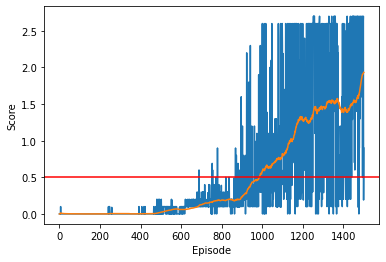

In [10]:
fig = plt.figure()
plt.plot(np.arange(len(scores)),scores)
plt.plot(np.arange(len(average_scores)),average_scores)
plt.axhline(y=0.5,color='r')
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()

### 6 Watch Smart Agent play in the current environment.

We can load this weights to watch the smart agent play as shown in the next cell. 

In [17]:
NUMBER_OF_EPISODES = 6

#Instantiate untrained agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=8)
#Load actor weights from file
agent.actor_local.load_state_dict(torch.load('actor_best.pth'))
#Load critic weights from file
agent.critic_local.load_state_dict(torch.load('critic_best.pth'))

for i in range(NUMBER_OF_EPISODES):
    env_info = env.reset(train_mode=False)[brain_name]
    player1_state = env_info.vector_observations[0]
    player2_state = env_info.vector_observations[1]
        
    agent.reset()
    scores = np.zeros(num_agents)
    while True:
        player1_action = agent.act(player1_state)
        player2_action = agent.act(player2_state)
            
        actions = np.vstack([player1_action, player2_action])
        env_info = env.step(actions)[brain_name]
            
        player1_next_state = env_info.vector_observations[0]
        player2_next_state = env_info.vector_observations[1]
            
        rewards = env_info.rewards
        dones = env_info.local_done
        
        player1_state = player1_next_state
        player2_state = player2_next_state

        scores += rewards

        if np.any(dones):
            break
        
    if  np.max(scores)>= 0.5:
        print("Congratulations your score is {}".format(np.max(scores)))
    else:
        print("Buh! you only scored {}. Try again".format(np.max(scores)))

Congratulations your score is 2.2000000327825546
Congratulations your score is 2.600000038743019
Congratulations your score is 2.600000038743019
Buh! you only scored 0.10000000149011612. Try again
Congratulations your score is 2.600000038743019
Congratulations your score is 0.800000011920929


### 7 Close the environment

In [18]:
env.close()